In [2]:
import numpy as np
import h5py

In [3]:
hdf = h5py.File('data/quark-gluon_data-set_n139306.hdf5','r')
dset_X_jets = hdf['X_jets']
dset_m0 = hdf['m0']
dset_pt = hdf['pt']
dset_y = hdf['y']

In [3]:
print(dset_X_jets, dset_m0, dset_pt,dset_y)

<HDF5 dataset "X_jets": shape (139306, 125, 125, 3), type "<f4"> <HDF5 dataset "m0": shape (139306,), type "<f4"> <HDF5 dataset "pt": shape (139306,), type "<f4"> <HDF5 dataset "y": shape (139306,), type "<f4">


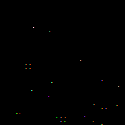

In [4]:
from PIL import Image
Image.fromarray(dset_X_jets[0],'RGB')
Image.fromarray(dset_X_jets[4],'RGB')


Track depiction : 


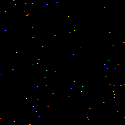

In [5]:
from PIL import Image
print("Track depiction : ")
Image.fromarray(dset_X_jets[0][:,:,0],'RGB')

ECAL depiction : 


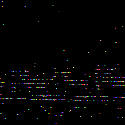

In [6]:
from PIL import Image
print("ECAL depiction : ")
Image.fromarray(dset_X_jets[0][:,:,1],'RGB')

HCAL depiction : 


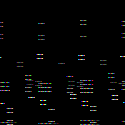

In [7]:
from PIL import Image
print("HCAL depiction : ")
Image.fromarray(dset_X_jets[0][:,:,2],'RGB')

In [8]:
import torch
from denoising_diffusion_pytorch import Unet, GaussianDiffusion

/Users/aman/Developer/diffusion/env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Set the device to GPU if available
device = torch.device("MPS" if torch.cuda.is_available() else "cpu")

# Define the VAE model
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder
        self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.fc1 = nn.Linear(128 * 15 * 15, 1024)
        self.fc21 = nn.Linear(1024, 256)
        self.fc22 = nn.Linear(1024, 256)

        # Decoder
        self.fc3 = nn.Linear(256, 1024)
        self.fc4 = nn.Linear(1024, 128 * 15 * 15)
        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1)

    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 128 * 15 * 15)
        x = F.relu(self.fc1(x))
        mu = self.fc21(x)
        logvar = self.fc22(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def decode(self, z):
        z = F.relu(self.fc3(z))
        z = F.relu(self.fc4(z))
        z = z.view(-1, 128, 15, 15)
        z = F.relu(self.deconv1(z))
        z = F.relu(self.deconv2(z))
        z = torch.sigmoid(self.deconv3(z))
        return z

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

# Define the loss function
def loss_function(x_recon, x, mu, logvar):
    BCE = F.binary_cross_entropy(x_recon, x.view(-1, 3, 125, 125), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Define the dataset and data loader
transform = transforms.Compose([
    transforms.Resize((125, 125)),
    transforms.ToTensor(),
])

In [6]:
train_set = torch.tensor(dset_X_jets[0:20])
train_set = torch.reshape(train_set,(-1,3,125,125))

In [7]:
model = model.VAE

torch.Size([20, 3, 125, 125])